AKTA 시스템은 단백질 정제 과정에서 널리 사용되는 크로마토그래피 시스템입니다. 과거에는 GE healthcare에서 현재는 Cytiva사에서 판매되고 있으며 자체 소프트웨어 UNICORN를 제공합니다. 여기서는 UNICORN에서 추출한 스프레드 시트 데이터를 사용해  크로마토그래피 그래프를 생성하는 방법을 알아보겠습니다. 데이터 처리부터 시각화까지 단계별로 파이썬을 사용하였습니다.

In [ ]:
import os

import matplotlib.pyplot as plt
import pandas as pd


def read_and_preprocess_data(file_path: str) -> pd.DataFrame:
    """엑셀 파일을 읽고 전처리하는 함수"""
    # 엑셀 파일 읽기 (상위 2행 스킵)
    df = pd.read_excel(file_path, index_col=False, skiprows=[0, 1])

    # 컬럼 이름 변경
    new_columns = [
        "ml",
        "mAU",
        "ml_1",
        "mS_cm",
        "ml_2",
        "percent",
        "ml_3",
        "%B",
        "ml_4",
        "pH",
        "ml_5",
        "MPa",
        "ml_6",
        "ml_min",
        "ml_7",
        "temperature_C",
        "ml_8",
        "Frac",
        "ml_9",
        "Injections",
        "ml_10",
        "Set_Marks",
    ]
    df.columns = new_columns

    # %B 값 수정
    elution_start = df[df["Set_Marks"] == "Block Isocratic_Elution"]["ml_10"].values[0]
    df["%B"] = df["ml"].apply(lambda x: 100 if x >= elution_start else 0)

    return df


def setup_plot() -> tuple[plt.Figure, plt.Axes]:
    """플롯 초기 설정"""
    fig, ax_main = plt.subplots(figsize=(10, 6))
    plt.subplots_adjust(top=0.85)
    return fig, ax_main


def plot_mau(ax: plt.Axes, df: pd.DataFrame) -> None:
    """mAU 데이터 플로팅"""
    ax.plot(df["ml"], df["mAU"], color="blue", label="mAU")
    ax.fill_between(df["ml"], df["mAU"], color="lightblue", alpha=0.3)
    ax.set_xlabel("ml")
    ax.set_ylabel("mAU", color="blue")
    ax.set_ylim(0, 2500)
    ax.tick_params(axis="y", labelcolor="blue")


def plot_b_percentage(ax: plt.Axes, df: pd.DataFrame) -> plt.Axes:
    """%B 데이터 플로팅"""
    ax_b = ax.twinx()
    ax_b.plot(df["ml"], df["%B"], color="red", label="%B")
    ax_b.set_ylabel("%B", color="red")
    ax_b.tick_params(axis="y", labelcolor="red")
    return ax_b


def plot_ph(ax: plt.Axes, df: pd.DataFrame) -> plt.Axes:
    """pH 데이터 플로팅"""
    ax_ph = ax.twinx()
    ax_ph.plot(df["ml_4"], df["pH"], color="green", label="pH")
    ax_ph.set_ylabel("pH", color="green")
    ax_ph.set_ylim(0, 12)
    ax_ph.tick_params(axis="y", labelcolor="green")
    ax_ph.spines["right"].set_position(("outward", 60))
    return ax_ph


def add_fraction_lines(ax: plt.Axes, df: pd.DataFrame) -> None:
    """분획 정보 표시"""
    for _, row in df.iterrows():
        if pd.notna(row["Frac"]):
            ax.axvline(x=row["ml_8"], color="gray", linestyle="--", alpha=0.5)
            ax.text(
                row["ml_8"],
                ax.get_ylim()[1],
                row["Frac"],
                rotation=90,
                va="top",
                ha="right",
            )


def add_combined_legend(axes: list[plt.Axes]) -> None:
    """모든 축의 범례 통합"""
    lines, labels = [], []
    for ax in axes:
        ax_lines, ax_labels = ax.get_legend_handles_labels()
        lines.extend(ax_lines)
        labels.extend(ax_labels)
    axes[0].legend(lines, labels, loc="upper left")


def process_and_plot_file(file_path: str) -> None:
    """단일 파일 처리 및 플로팅"""
    print(f"Processing file: {os.path.basename(file_path)}")

    df = read_and_preprocess_data(file_path)
    fig, ax_main = setup_plot()

    plot_mau(ax_main, df)
    ax_b = plot_b_percentage(ax_main, df)
    ax_ph = plot_ph(ax_main, df)
    add_fraction_lines(ax_main, df)
    add_combined_legend([ax_main, ax_b, ax_ph])

    plt.title(f"{os.path.basename(file_path)} Plot", y=1.01)
    ax_main.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()


def process_folder(folder_path: str) -> None:
    """폴더 내 모든 .xls 파일 처리"""
    for filename in os.listdir(folder_path):
        if filename.endswith(".xls"):
            file_path = os.path.join(folder_path, filename)
            process_and_plot_file(file_path)


# 데이터 살펴보기

UNICORN 소프트웨어에서 실험 데이터를 엑셀 파일로 저장할 수 있고 일반적으로 다음과 같은 구조를 가집니다:

- 헤더 정보: 실험 조건, 날짜, 시간 등
- 컬럼 헤더: 각 데이터 열의 이름과 단위
- 데이터 행: 시간에 따른 다양한 측정값

데이터 테이블을 출력해 확인해 봅니다. 

In [ ]:
df = pd.read_excel("../data/input/AKTA_run_1.xls", index_col=False, skiprows=[0, 1])
df.head()


,ml,mAU,ml.1,mS/cm,ml.2,%,ml.3,%B,ml.4,,...,ml.6,ml/min,ml.7,°C,ml.8,(Fractions),ml.9,(Injections),ml.10,(Set Marks)
0,0.000000,-0.099,0.000000,14.197,0.000000,14.2,0.000000,0.0,0.000000,6.86,...,0.000000,14.98,0.000000,26.3,-0.3,A1,0.0,3.0,-12.47,"Method Run 11/21/2024, 2:05:53 PM Korea Standa..."
1,0.095014,-0.091,0.095257,14.198,0.190336,14.2,0.190336,0.0,0.095257,6.86,...,0.095257,14.50,0.381111,26.3,9.7,A2,NaN,NaN,-12.47,Batch ID: 14DB55F2-E6A8-4734-8806-041C9AA49E11
2,0.190028,-0.081,0.190514,14.199,0.380673,14.2,0.380673,0.0,0.190514,6.87,...,0.190514,13.54,0.762222,26.3,19.7,A3,NaN,NaN,-12.47,"Base CV, 0.40 {ml}"
3,0.285042,-0.074,0.285772,14.203,0.571009,14.2,0.571009,0.0,0.285772,6.87,...,0.285772,8.78,1.143333,26.2,29.7,A4,NaN,NaN,-12.47,Block Start_with_PumpWash_Purifier
4,0.380056,-0.067,0.381029,14.204,0.761346,14.2,0.761346,0.0,0.381029,6.87,...,0.381029,8.00,1.524444,26.2,39.7,A5,NaN,NaN,-12.47,Base SameAsMain


## 주요 데이터 열 확인하기

파일에서 흔히 볼 수 있는 주요 데이터 열은 다음과 같습니다:

- ml (Volume): 용출 부피
- mAU (UV Absorbance): 자외선 흡광도
- mS/cm (Conductivity): 전도도
- %B (Buffer B Concentration): 버퍼 B의 농도 비율
- pH: pH 값
- MPa (Pressure): 시스템 압력
- °C (Temperature): 온도
- Fractions: 분획 번호

# 시각화 하기

Processing file: AKTA_run_2.xls


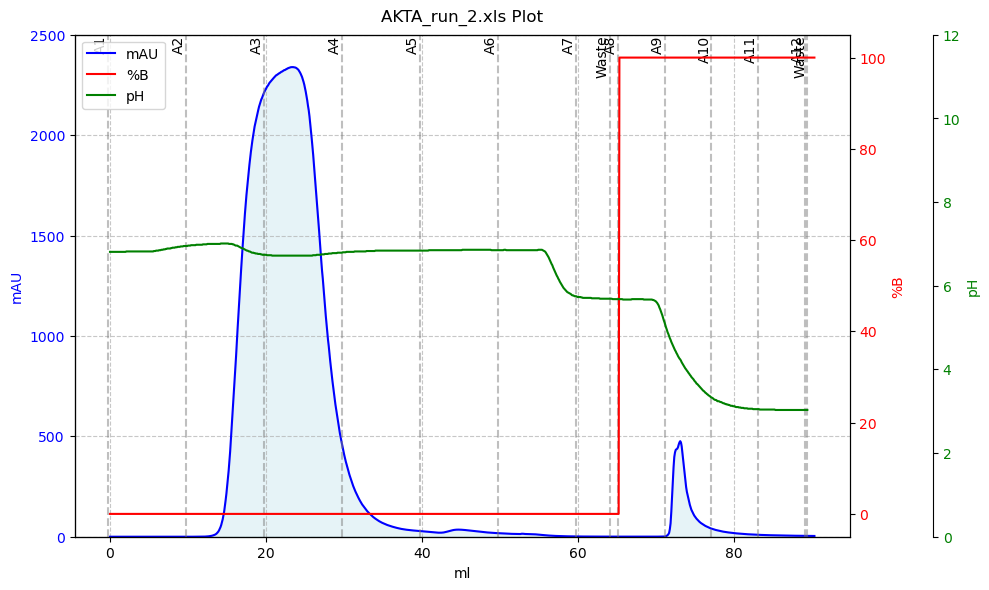

Processing file: AKTA_run_3.xls


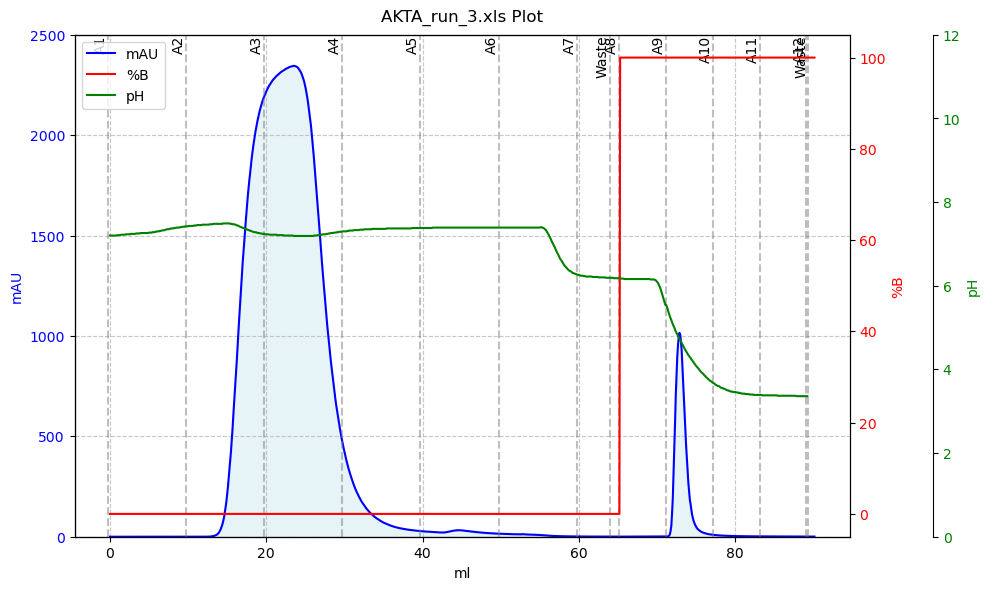

Processing file: AKTA_run_1.xls


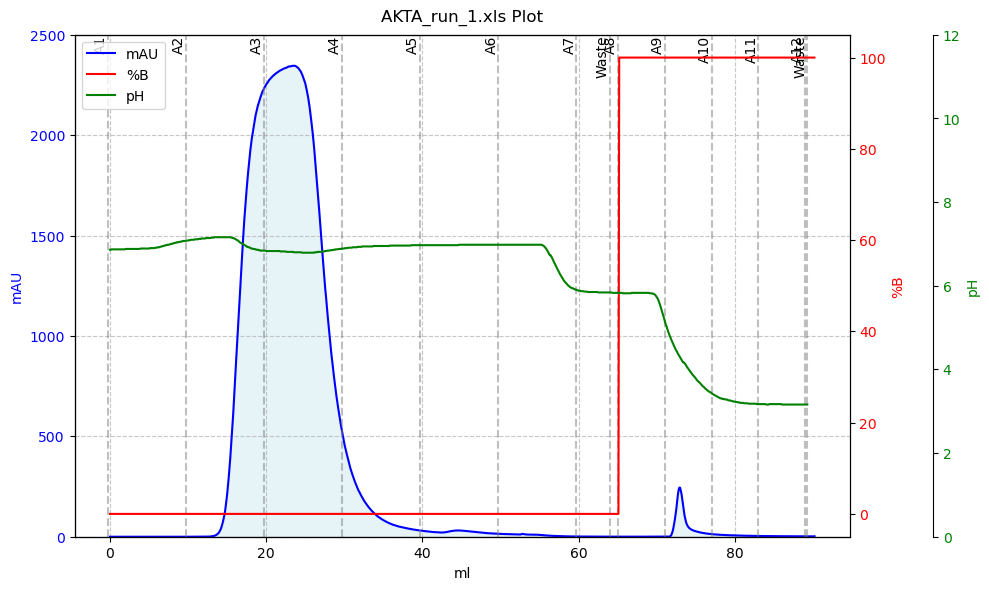

Processing file: AKTA_run_4.xls


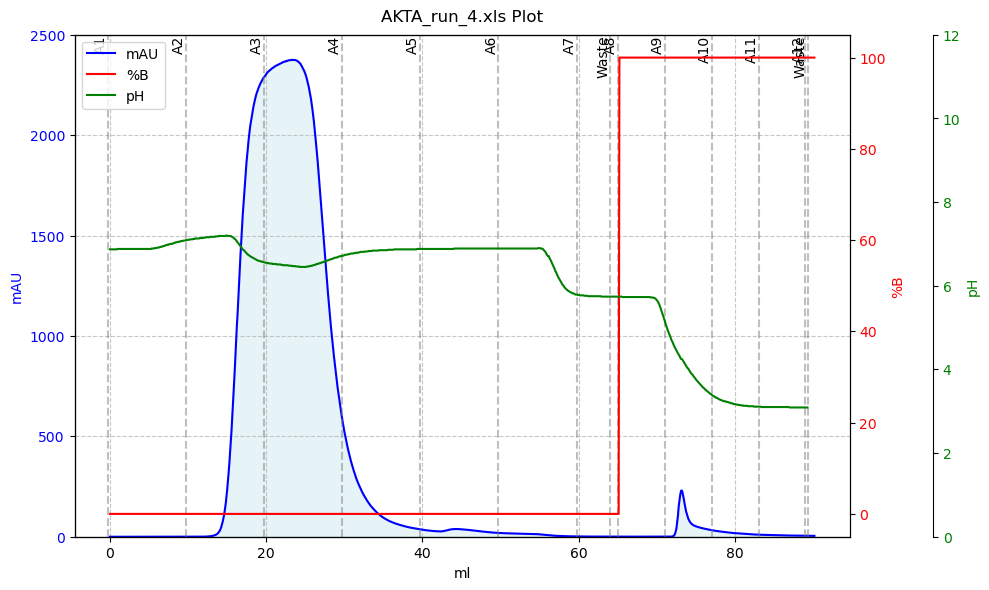

In [ ]:
# 여기에 폴더 경로를 입력하세요.
folder_path = "../data/input"
process_folder(folder_path)


생성된 그래프를 통해 다음과 같은 정보를 얻을 수 있습니다:

- mAU 값의 변화: 단백질 농도 변화 추적
- %B 값의 변화: 버퍼 농도 변화 확인
- pH 변화: 용출 조건 모니터링
- 분획 정보: 각 분획의 위치 확인

# 결론

이 방법을 통해 AKTA 데이터를 효과적으로 시각화할 수 있으며 이는 단백질 정제 과정의 최적화와 결과 해석에 큰 도움이 될 것입니다.